# Compare NEON and PRISM data:

### Use this notebook to generate timeseries & cumulative precipitation plots

In [1]:
# Import Libraries
%matplotlib inline
from datetime import datetime
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Choose site and retrieve PRISM data

In [2]:
# Choose Year and Site (please use strings, e.g. put quotes around the year, as well)
year = '2021'
site = 'OAES'

In [3]:
# Get prism data for particular year and site
pd.set_option('mode.chained_assignment', None)
prism_files_per_year = {'2018': 'PRISM_ppt_tmean_stable_4km_20180101_20181231.csv',
                        '2019': 'PRISM_ppt_tmean_stable_4km_20190101_20191231.csv',
                        '2020': 'PRISM_ppt_tmean_stable_4km_20200101_20201231.csv',
                        '2021': 'PRISM_ppt_tmean_stable_4km_20210101_20211231.csv',
                        '2022': 'PRISM_ppt_tmean_stable_4km_20220101_20220531.csv'}

# perform conversions and gather relevant data
prism_df = pd.read_csv(prism_files_per_year[year], sep=';')

# find relevant rows based on whether or not site is in cell
prism_data = prism_df[prism_df['PRISM Time Series Data'].str.contains(site)]

new_df = prism_data["PRISM Time Series Data"].str.split(",", expand = True)

prism_data["Precip"] = new_df[5]  # rain is 6th value in csv file, indexing starts at 0, so index #6
prism_data["Time"] = new_df[4]  # date is 5th value in csv file, indexing starts at 0, so index #4

# Perform unit conversions
prism_data['Precip'] = prism_data['Precip'].astype(float)

In [4]:
# read in NEON data
half_hourly_files = '/glade/work/tking/ctsm_tking/tools/site_and_regional/{}.transient/run/inputdata/atm/cdeps/v2/{}/{}_atm_{}-*.nc'.format(site,site,site,year)
half_hourly_neon_dataset = xr.open_mfdataset(half_hourly_files, parallel=True)

In [5]:
# resample NEON data to be daily
daily_neon_prect_dataset = half_hourly_neon_dataset['PRECTmms'].resample(time='1D').mean()

# get correct units (mm/s * (3600s/hr) * (24hr/day) = mm/day)
daily_neon_prect = daily_neon_prect_dataset[:,0,0] * 3600 * 24 

In [6]:
prism_time_vals = prism_data['Time']
prism_precip_vals = prism_data['Precip']

prism_times=[]
for val in prism_time_vals:
    prism_times.append(datetime.strptime(val,'%Y-%m-%d'))

In [7]:
# You can double check which values are being pulled from the csv file with this cell
prism_data

,PRISM Time Series Data,Precip,Time
9865,"OAES,-99.0604,35.4106,512,2021-01-01,10.29,-1.0",10.29,2021-01-01
9866,"OAES,-99.0604,35.4106,512,2021-01-02,3.03,2.5",3.03,2021-01-02
9867,"OAES,-99.0604,35.4106,512,2021-01-03,0.51,3.8",0.51,2021-01-03
9868,"OAES,-99.0604,35.4106,512,2021-01-04,0.00,5.3",0.00,2021-01-04
9869,"OAES,-99.0604,35.4106,512,2021-01-05,0.00,7.6",0.00,2021-01-05
...,...,...,...
10225,"OAES,-99.0604,35.4106,512,2021-12-27,0.00,16.4",0.00,2021-12-27
10226,"OAES,-99.0604,35.4106,512,2021-12-28,0.00,9.5",0.00,2021-12-28
10227,"OAES,-99.0604,35.4106,512,2021-12-29,0.00,10.2",0.00,2021-12-29
10228,"OAES,-99.0604,35.4106,512,2021-12-30,0.00,8.1",0.00,2021-12-30


### Calendar year daily precipitation plot

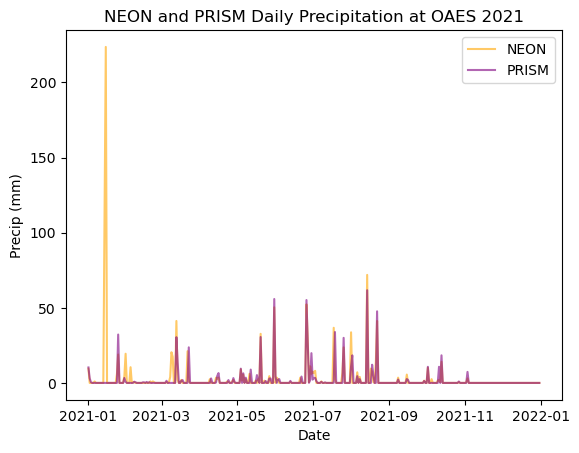

In [8]:
# Plot datasets
plt.plot(daily_neon_prect['time'], daily_neon_prect, label="NEON", color="orange", alpha=0.6)
plt.plot(prism_times,prism_precip_vals, label='PRISM', color='purple', alpha=0.6)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("NEON and PRISM Daily Precipitation at {} {}".format(site, year))
plt.legend()
plt.show()

### Calendar year cumulative precipitation plot

In [9]:
# sum PRISM precip values over the course of the year
cumulative_prism_precip_vals=[]
for index in range(0, len(prism_data)):
    cumulative_val = prism_precip_vals.iloc[:index].sum()
    cumulative_prism_precip_vals.append(cumulative_val)

# NEON data is in different format
daily_neon_prect_array = daily_neon_prect.compute()
cumulative_daily_neon_prect = []
for index in range(0, len(prism_data)):
    cumulative_val = np.sum(daily_neon_prect_array[:index])
    cumulative_daily_neon_prect.append(cumulative_val)

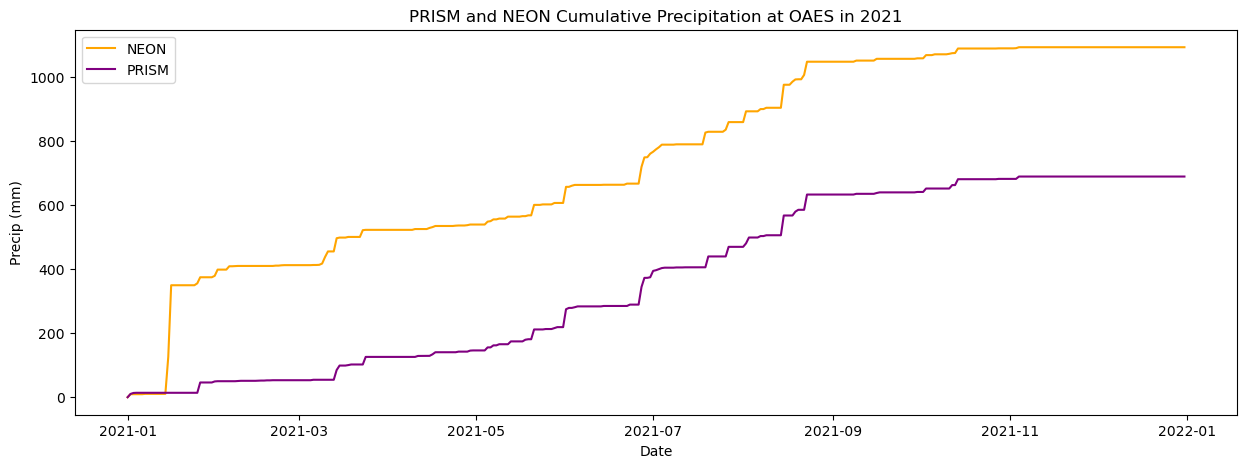

In [10]:
# Plot cumulative precipitation
# Note that for 2022, x/y values besides cumulative_daily_neon_prect must be truncated
plt.plot(daily_neon_prect['time'], cumulative_daily_neon_prect, label="NEON", color="orange", alpha=1)
plt.plot(prism_times, cumulative_prism_precip_vals, label='PRISM', color='purple', alpha=1)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("PRISM and NEON Cumulative Precipitation at {} in {}".format(site, year))
plt.legend()
plt.show()
# plt.savefig("Precip_{}_{}".format(site, year))